# Day 7: Complete Production Trading System

## Learning Objectives
- Build end-to-end production system
- Combine all components from the week
- Professional trading pipeline

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from scipy import stats
import datetime
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

print("✅ Libraries loaded!")
print("📚 Day 7: Complete Production Trading System")

✅ Libraries loaded!
📚 Day 7: Complete Production Trading System


## Part 1: Complete System Components

In [2]:
# ============================================================
# FEATURE ENGINEERING MODULE
# ============================================================

class FeatureEngine:
    """Feature engineering pipeline."""
    
    def __init__(self):
        self.feature_names = ['ret_5d', 'vol_5d', 'mom_5d', 'vol_ratio']
        
    def compute_features(self, df):
        """Compute features from price data."""
        features = pd.DataFrame(index=df.index)
        
        features['ret_5d'] = df['price'].pct_change(5)
        features['vol_5d'] = df['returns'].rolling(5).std()
        features['mom_5d'] = df['returns'].rolling(5).sum()
        features['vol_ratio'] = features['vol_5d'] / df['returns'].rolling(20).std()
        
        return features

print("✅ FeatureEngine defined")

✅ FeatureEngine defined


In [3]:
# ============================================================
# RISK MANAGER MODULE
# ============================================================

class RiskManager:
    """Risk management and position sizing."""
    
    def __init__(self, max_position=1.0, target_vol=0.15, max_drawdown=-0.15):
        self.max_position = max_position
        self.target_vol = target_vol
        self.max_drawdown = max_drawdown
        
        self.peak_equity = 1.0
        self.current_equity = 1.0
        self.in_drawdown_mode = False
        
    def calculate_position_size(self, signal_strength, realized_vol):
        """Calculate position size with risk controls."""
        
        # Base size from signal
        base_size = signal_strength * self.max_position
        
        # Volatility scaling
        if realized_vol > 0:
            vol_scale = min(self.target_vol / realized_vol, 2.0)
        else:
            vol_scale = 1.0
        
        # Drawdown scaling
        current_dd = (self.current_equity - self.peak_equity) / self.peak_equity
        if current_dd < self.max_drawdown:
            self.in_drawdown_mode = True
            dd_scale = 0.3  # Reduce exposure
        elif self.in_drawdown_mode and current_dd > self.max_drawdown / 2:
            self.in_drawdown_mode = False
            dd_scale = 1.0
        else:
            dd_scale = 0.3 if self.in_drawdown_mode else 1.0
        
        position = base_size * vol_scale * dd_scale
        position = np.clip(position, -self.max_position, self.max_position)
        
        return position
    
    def update_equity(self, pnl):
        """Update equity tracking."""
        self.current_equity *= (1 + pnl)
        self.peak_equity = max(self.peak_equity, self.current_equity)
        
    def get_current_drawdown(self):
        return (self.current_equity - self.peak_equity) / self.peak_equity

print("✅ RiskManager defined")

✅ RiskManager defined


In [4]:
# ============================================================
# TRANSACTION COST MODULE
# ============================================================

class CostModel:
    """Transaction cost modeling."""
    
    def __init__(self, commission=0.001, spread=0.0005, slippage=0.0002):
        self.commission = commission
        self.spread = spread
        self.slippage = slippage
        
    def calculate_cost(self, position_change):
        """Calculate cost for position change."""
        one_way_cost = self.commission + self.spread + self.slippage
        return abs(position_change) * one_way_cost

print("✅ CostModel defined")

✅ CostModel defined


In [5]:
# ============================================================
# MONITORING MODULE
# ============================================================

class Monitor:
    """System monitoring."""
    
    def __init__(self, alert_accuracy_threshold=0.48):
        self.alert_threshold = alert_accuracy_threshold
        self.predictions = []
        self.actuals = []
        self.alerts = []
        
    def log_prediction(self, pred, actual):
        self.predictions.append(pred)
        self.actuals.append(actual)
        
        # Check rolling accuracy
        if len(self.predictions) >= 50:
            rolling_acc = np.mean(np.array(self.predictions[-50:]) == np.array(self.actuals[-50:]))
            if rolling_acc < self.alert_threshold:
                self.alerts.append(f"Low accuracy: {rolling_acc:.1%}")
    
    def get_accuracy(self, window=None):
        if window is None:
            preds = self.predictions
            acts = self.actuals
        else:
            preds = self.predictions[-window:]
            acts = self.actuals[-window:]
        return np.mean(np.array(preds) == np.array(acts))

print("✅ Monitor defined")

✅ Monitor defined


## Part 2: Complete Trading System

In [6]:
# ============================================================
# COMPLETE TRADING SYSTEM
# ============================================================

class TradingSystem:
    """Production trading system."""
    
    def __init__(self):
        self.feature_engine = FeatureEngine()
        self.risk_manager = RiskManager()
        self.cost_model = CostModel()
        self.monitor = Monitor()
        
        self.model = None
        self.scaler = None
        
        self.current_position = 0
        self.trade_log = []
        
    def train(self, df):
        """Train the model."""
        # Generate features
        features = self.feature_engine.compute_features(df)
        features['target'] = (df['returns'].shift(-1) > 0).astype(int)
        features = features.dropna()
        
        X = features[self.feature_engine.feature_names].values
        y = features['target'].values
        
        # Scale
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)
        
        # Train
        self.model = GradientBoostingClassifier(n_estimators=50, max_depth=3, random_state=42)
        self.model.fit(X_scaled, y)
        
        print(f"✅ Model trained on {len(X)} samples")
        
    def generate_signal(self, features):
        """Generate trading signal."""
        X = np.array(features).reshape(1, -1)
        X_scaled = self.scaler.transform(X)
        
        pred = self.model.predict(X_scaled)[0]
        prob = self.model.predict_proba(X_scaled)[0, 1]
        
        # Signal strength from probability
        signal_strength = 2 * prob - 1  # Maps [0,1] to [-1,1]
        
        return {
            'direction': 1 if pred == 1 else -1,
            'strength': signal_strength,
            'confidence': prob
        }
    
    def execute_step(self, features, market_return, realized_vol):
        """
        Execute one trading step.
        
        Returns:
            Dict with step results
        """
        # Generate signal
        signal = self.generate_signal(features)
        
        # Calculate position
        target_position = self.risk_manager.calculate_position_size(
            signal['strength'], realized_vol
        )
        
        # Position change and costs
        position_change = target_position - self.current_position
        cost = self.cost_model.calculate_cost(position_change)
        
        # PnL
        gross_pnl = self.current_position * market_return
        net_pnl = gross_pnl - cost
        
        # Update state
        self.risk_manager.update_equity(net_pnl)
        self.current_position = target_position
        
        # Log
        actual_direction = 1 if market_return > 0 else 0
        self.monitor.log_prediction(signal['direction'] > 0, actual_direction)
        
        result = {
            'signal': signal,
            'position': target_position,
            'position_change': position_change,
            'cost': cost,
            'gross_pnl': gross_pnl,
            'net_pnl': net_pnl,
            'equity': self.risk_manager.current_equity,
            'drawdown': self.risk_manager.get_current_drawdown()
        }
        
        self.trade_log.append(result)
        
        return result
    
    def backtest(self, df, train_pct=0.6):
        """Run walk-forward backtest."""
        
        # Split
        train_end = int(len(df) * train_pct)
        df_train = df.iloc[:train_end]
        df_test = df.iloc[train_end:]
        
        # Train
        self.train(df_train)
        
        # Generate features for test
        features_test = self.feature_engine.compute_features(df_test)
        features_test = features_test.dropna()
        
        # Backtest
        print("\n🔄 Running backtest...")
        
        for i in range(len(features_test) - 1):
            feat_values = features_test[self.feature_engine.feature_names].iloc[i].values
            market_return = df_test['returns'].iloc[features_test.index.get_loc(features_test.index[i]) + 1]
            realized_vol = features_test['vol_5d'].iloc[i] * np.sqrt(252)
            
            self.execute_step(feat_values, market_return, realized_vol)
        
        print(f"✅ Backtest complete: {len(self.trade_log)} steps")
        
        return self.get_results()
    
    def get_results(self):
        """Get backtest results."""
        log = pd.DataFrame(self.trade_log)
        
        # Calculate metrics
        total_return = log['equity'].iloc[-1] - 1
        sharpe = np.sqrt(252) * log['net_pnl'].mean() / log['net_pnl'].std()
        max_dd = log['drawdown'].min()
        total_costs = log['cost'].sum()
        turnover = log['position_change'].abs().sum() / 2
        accuracy = self.monitor.get_accuracy()
        
        return {
            'total_return': total_return,
            'sharpe': sharpe,
            'max_drawdown': max_dd,
            'total_costs': total_costs,
            'turnover': turnover,
            'accuracy': accuracy,
            'n_trades': len(log),
            'log': log
        }

print("✅ TradingSystem defined")

✅ TradingSystem defined


## Part 3: Run Complete System

In [7]:
# ============================================================
# GENERATE DATA & RUN SYSTEM
# ============================================================

print("RUNNING COMPLETE TRADING SYSTEM")
print("="*60)

# Generate data
np.random.seed(42)
n_days = 2000

returns = np.random.normal(0.0003, 0.015, n_days)
for i in range(1, len(returns)):
    returns[i] += 0.05 * returns[i-1]

prices = 100 * np.cumprod(1 + returns)
df = pd.DataFrame({
    'price': prices,
    'returns': returns
}, index=pd.date_range('2020-01-01', periods=n_days))

# Initialize and run system
system = TradingSystem()
results = system.backtest(df, train_pct=0.6)

RUNNING COMPLETE TRADING SYSTEM
✅ Model trained on 1181 samples

🔄 Running backtest...
✅ Backtest complete: 780 steps


In [8]:
# ============================================================
# DISPLAY RESULTS
# ============================================================

print("\n" + "="*60)
print("TRADING SYSTEM RESULTS")
print("="*60)

print(f"\nPerformance Metrics:")
print(f"  Total Return: {results['total_return']*100:.1f}%")
print(f"  Sharpe Ratio: {results['sharpe']:.2f}")
print(f"  Max Drawdown: {results['max_drawdown']*100:.1f}%")
print(f"  Accuracy: {results['accuracy']*100:.1f}%")

print(f"\nTrading Statistics:")
print(f"  Total Trades: {results['n_trades']}")
print(f"  Total Costs: {results['total_costs']*100:.2f}%")
print(f"  Turnover: {results['turnover']:.0f}x")


TRADING SYSTEM RESULTS

Performance Metrics:
  Total Return: -1.8%
  Sharpe Ratio: -0.13
  Max Drawdown: -8.4%
  Accuracy: 51.5%

Trading Statistics:
  Total Trades: 780
  Total Costs: 15.47%
  Turnover: 45x


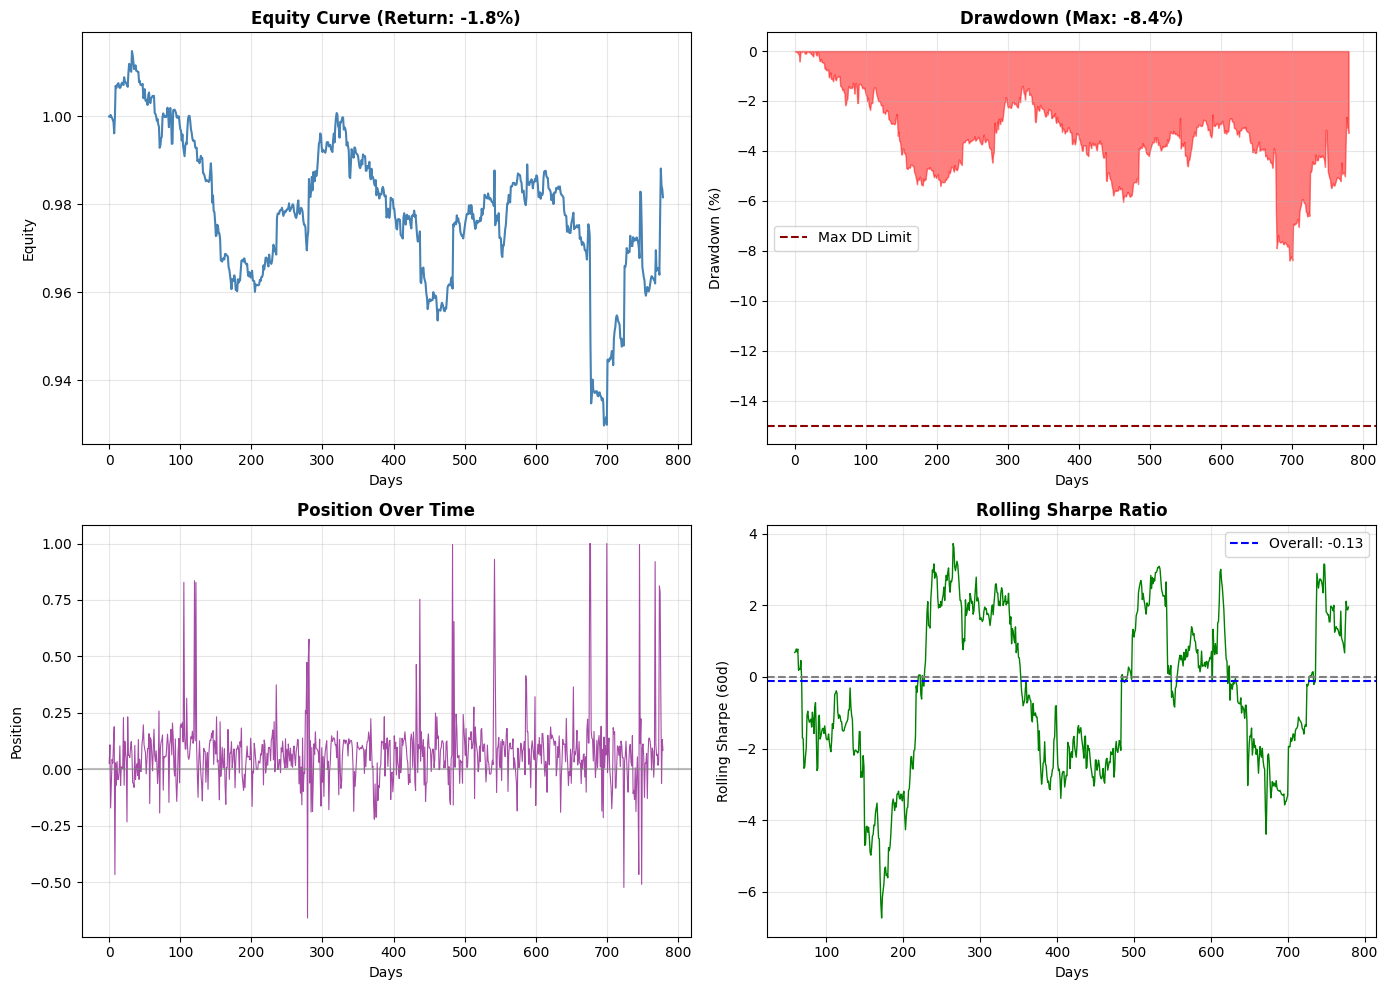

In [9]:
# ============================================================
# VISUALIZATION
# ============================================================

log = results['log']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Equity curve
axes[0, 0].plot(log['equity'], color='steelblue', linewidth=1.5)
axes[0, 0].set_xlabel('Days')
axes[0, 0].set_ylabel('Equity')
axes[0, 0].set_title(f'Equity Curve (Return: {results["total_return"]*100:.1f}%)', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Drawdown
axes[0, 1].fill_between(range(len(log)), log['drawdown']*100, 0, color='red', alpha=0.5)
axes[0, 1].axhline(-15, color='darkred', linestyle='--', label='Max DD Limit')
axes[0, 1].set_xlabel('Days')
axes[0, 1].set_ylabel('Drawdown (%)')
axes[0, 1].set_title(f'Drawdown (Max: {results["max_drawdown"]*100:.1f}%)', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Position over time
axes[1, 0].plot(log['position'], color='purple', alpha=0.7, linewidth=0.8)
axes[1, 0].axhline(0, color='gray', linestyle='-', alpha=0.5)
axes[1, 0].set_xlabel('Days')
axes[1, 0].set_ylabel('Position')
axes[1, 0].set_title('Position Over Time', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Rolling Sharpe
rolling_sharpe = log['net_pnl'].rolling(60).apply(lambda x: np.sqrt(252) * x.mean() / x.std())
axes[1, 1].plot(rolling_sharpe, color='green', linewidth=1)
axes[1, 1].axhline(0, color='gray', linestyle='--')
axes[1, 1].axhline(results['sharpe'], color='blue', linestyle='--', label=f'Overall: {results["sharpe"]:.2f}')
axes[1, 1].set_xlabel('Days')
axes[1, 1].set_ylabel('Rolling Sharpe (60d)')
axes[1, 1].set_title('Rolling Sharpe Ratio', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
print("""
╔══════════════════════════════════════════════════════════════════╗
║        DAY 7 COMPLETE: PRODUCTION TRADING SYSTEM                 ║
╠══════════════════════════════════════════════════════════════════╣
║  ✓ Feature engineering module                                   ║
║  ✓ Risk management with drawdown control                        ║
║  ✓ Transaction cost modeling                                    ║
║  ✓ Performance monitoring                                       ║
║  ✓ Complete backtesting pipeline                                ║
╚══════════════════════════════════════════════════════════════════╝

🎉 WEEK 12 COMPLETE! You've built a production trading system!

╔══════════════════════════════════════════════════════════════════╗
║           🏆 12-WEEK CURRICULUM COMPLETE! 🏆                     ║
╠══════════════════════════════════════════════════════════════════╣
║                                                                  ║
║  Week 1-4:   ML Foundations & Classical Methods                 ║
║  Week 5-8:   Advanced ML & Portfolio Optimization               ║
║  Week 9-10:  Deep Learning & Sequence Models                    ║
║  Week 11-12: Feature Engineering & Production Systems           ║
║                                                                  ║
║  You now have the skills to:                                    ║
║  • Build ML trading strategies from scratch                     ║
║  • Implement proper backtesting with realistic costs            ║
║  • Deploy production-ready systems with monitoring              ║
║  • Manage risk and avoid common pitfalls                        ║
║                                                                  ║
╚══════════════════════════════════════════════════════════════════╝
""")


╔══════════════════════════════════════════════════════════════════╗
║        DAY 7 COMPLETE: PRODUCTION TRADING SYSTEM                 ║
╠══════════════════════════════════════════════════════════════════╣
║  ✓ Feature engineering module                                   ║
║  ✓ Risk management with drawdown control                        ║
║  ✓ Transaction cost modeling                                    ║
║  ✓ Performance monitoring                                       ║
║  ✓ Complete backtesting pipeline                                ║
╚══════════════════════════════════════════════════════════════════╝

🎉 WEEK 12 COMPLETE! You've built a production trading system!

╔══════════════════════════════════════════════════════════════════╗
║           🏆 12-WEEK CURRICULUM COMPLETE! 🏆                     ║
╠══════════════════════════════════════════════════════════════════╣
║                                                                  ║
║  Week 1-4:   ML Foundations & Classical Met